In [16]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import multivariate_normal
from sklearn.preprocessing import  minmax_scale
import pandas as pd #easier to operate with, numpy based..!
from ipywidgets import interact
import timeit
import time
import os

In [4]:
#Folder and paths definitions
main_path  = os.getcwd()
datafolder_path = main_path+"/results"
results_dir = "/output_py" 
output_dir = main_path+results_dir
try:
    os.mkdir(output_dir)
except OSError:
    print ("Creation of the directory %s failed" % results_dir)
else:
    print ("Successfully created the directory %s " % results_dir)


Creation of the directory /output_py failed


In [5]:
def convert_to_df(mat,dtype="float32"): 
    #dataframes were used as they allowed computational times almost
    #as fast as numpy but with easier syntax/more useful built in functions 
    #for the present algorithm
    return pd.DataFrame(np.float32(mat))

def get_distrib_mat(grid):
    """Here only one step is needed in a given direction"""
    """but this can be easily be changed and n-steps in whatever direction"""
    """Given a grid (of PDF), returns values of the grid (n) steps in a given"""
    """direction of the grid."""
    df_grid = convert_to_df(grid)
    N = df_grid.shift(-1,axis=0,fill_value=0)  #looks 1 cell up
    E = df_grid.shift(-1,axis=1,fill_value=0) #looks 1 cell right
    S = df_grid.shift(1,axis=0,fill_value=0) #looks 1 cell down 
    W = df_grid.shift(1,axis=1,fill_value=0)  #looks 1 cell left 
    return N,E,S,W


#Coefficients propensity functions, from
#"Solution of the chemical master equation by
#radial basis functions approximation with
#interface tracking", Kryven et al

c1=c4 = 3e3
c2=c5 = 1.1e4
c3=c6 = 1e-3
beta = gamma = 2



def r1(i,j):
    return c1/(c2+j**beta)
def r2(i,j):
    return c3*i
def r3(i,j):
    return c4/(c5+i**gamma)
def r4(i,j):
    return c6*j

#mapping reaction functions
#Note that these coefficients are fixed during the exp, can be evaluated even just once!

#all weights for the reactions, here just examples to picture dynamics of time evolution
size = 300
a = np.zeros(shape=[4,size,size],dtype="float32")

for i in range(0,size):
    for j in range(0,size):
        a[0,i,j] = r1(i,j)
        a[1,i,j] = r2(i,j)
        a[2,i,j] = r3(i,j) 
        a[3,i,j] = r4(i,j) 

a_df=[]
a_df.append(convert_to_df(a[0,:,:]))
a_df.append(convert_to_df(a[1,:,:]))
a_df.append(convert_to_df(a[2,:,:]))
a_df.append(convert_to_df(a[3,:,:]))


In [6]:
#of each propensity grid, NESW
#e.g.: a0 looking to the element in N position = a0_df[0]
a0_df = get_distrib_mat(a_df[0])
a1_df = get_distrib_mat(a_df[1])
a2_df = get_distrib_mat(a_df[2])
a3_df = get_distrib_mat(a_df[3])


In [7]:
type(a0_df[1].iloc[0][0])

numpy.float32

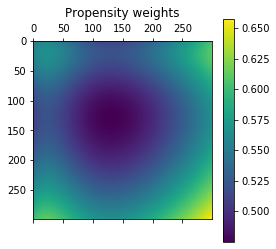

In [9]:
plt.matshow(a_df[0]+a_df[1]+a_df[2]+a_df[3])
plt.title("Propensity weights",y=1.1)
plt.colorbar()
plt.show()

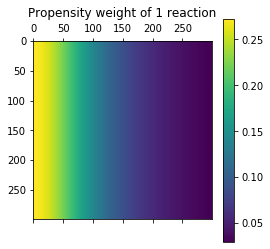

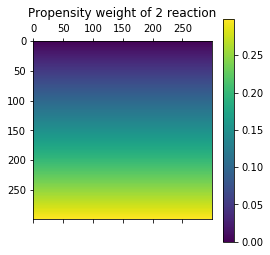

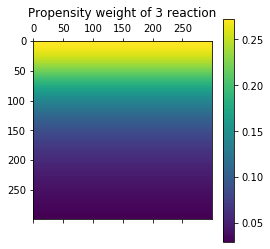

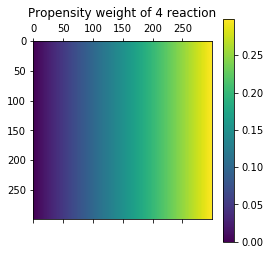

In [10]:
#Coefficients matrices
for i in range(0,4):
    plt.matshow(a_df[i])
    plt.title("Propensity weight of %d reaction"%(i+1),y=1.1)
    plt.colorbar()
    plt.show()
    #plt.clim(0, .5);

In [11]:
def create_size_folderdata(size):
    try:
        os.mkdir(output_dir+"/size=%d"%(size))
    except OSError:
        print ("")
    else:
        print ("Successfully created the directory %s " % output_dir+"/size=%d"%(size))
    return output_dir+"/size=%d"%(size)

#create_name/get data functions

def name_data(t_end,dt):
    """Create name of output file given simulation parameters"""
    data_name = "data_size%d_x0y0=%d_%d_std=%d_dt=%.5f_t_end=%d.dat"%(size,center[0],center[1],std,dt,t_end)
    return data_name

def get_data(output_path,t_end):
    """Get output file given simulation parameters"""
    data_name = "data_size%d_x0y0=%d_%d_std=%d_t=%d.dat"%(size,center[0],center[1],std,t_end)
    data = pd.read_csv(output_path,header=None,sep=",")
    return data


#visualization functions


def display_sequence_contourf(output_path,t_end):
    """Slider implementation of visualization over time"""
    data = get_data(output_path,t_end)
    def _show(frame=(0, t_end-1)):
        plt.style.use('seaborn-white')
        plt.title("%d step"%(frame),y=1.1)
        plt.contourf(get_configuration(data, frame),10,cmap='Spectral') # n equally spaced lines
        plt.colorbar()
        #plt.clim(0,1)
        plt.show()
    return interact(_show)

def get_configuration(data):
    """Get configuration from data at a given time"""
    return convert_to_df(np.asarray(data).reshape(size,size))

In [23]:
def time_ev_mat(grid,t_end=500,dt=.1):
    """Main of the simulation, returns path and name of the output file"""

    start_t = time.clock()
    t = 0  
    size = np.shape(grid)[0]
    dt_mat = np.full([size,size],fill_value=dt,dtype="float32")

    #propensity matrix
    a = np.zeros(shape=[4,size,size],dtype="float32")
    
    result_path_name = create_size_folderdata(size)
    
    filePath = result_path_name+"/"+name_data(t_end,dt)
 
    #to avoid overwrite
    if os.path.exists(filePath):
        os.remove(filePath)
    
    print("\n\n")
    ncolors = 20
    cmap ="jet"
    
    grid = convert_to_df(grid)
    for i in range(0,size):
        for j in range(0,size):
            a[0,i,j] = r1(i,j)
            a[1,i,j] = r2(i,j)
            a[2,i,j] = r3(i,j) 
            a[3,i,j] = r4(i,j) 

    a_df=[]
    a_df.append(convert_to_df(a[0,:,:]))
    a_df.append(convert_to_df(a[1,:,:]))
    a_df.append(convert_to_df(a[2,:,:]))
    a_df.append(convert_to_df(a[3,:,:]))
    plt.matshow(a_df[0]+a_df[1]+a_df[2]+a_df[3])
    plt.title("Propensity weights",y=1.1)#coefficients from paper
    plt.colorbar()
    plt.savefig(create_size_folderdata(size)+"/"+"propensity_map.png")
    plt.show()
    #of each propensity grid, NESW
    #e.g.: a0 looking to the element in N position = a0_df[0]
    a0_df = get_distrib_mat(a_df[0])
    a1_df = get_distrib_mat(a_df[1])
    a2_df = get_distrib_mat(a_df[2])
    a3_df = get_distrib_mat(a_df[3])
    increment = np.zeros([size,size])
    tgrid_saved = []
    t_save_every = t_end/(dt*100) #save only n configurations
    saved_counter = 0
    while t<int(t_end/dt): #not to lose last step
        #running flag
        if(t%int(t_end/(500*dt)))==0: #display every n
            #print(type(grid.iloc[0][1]))
            print("Effective time = %.4f\n"%(dt*t))
            print("Process @%d/%d (%.2f/100)"%(t,t_end/dt,(100*(t*dt)/t_end)))
            print("Normalized sum of grid %.8f"%(sum(sum(grid.values))/(size*size)))
            print("Elapsed time = %.3fseconds\n"%(time.clock()-start_t))  
            plt.figure(figsize=[8,8])
            plt.title("$(x_{0},y_{0})$=(%d,%d), $\\sigma=%d$, t=%.3f, dt=%.3f"%(center[0],center[1],std,t*dt,dt),fontsize=20)
            plt.contourf(grid,ncolors,cmap=cmap)
            plt.colorbar()
            plt.savefig(create_size_folderdata(size)+"/"+"plot_configs_size=%d_center=(%d_%d)_std=%d_dt=%.5f_t=%.3f.png"%(size,center[0],center[1],std,dt,t*dt))
            plt.show()
            #not to lose first step
        #here configurations are saved as 1D arrays, one per each time step
        if(t%t_save_every)==0:
            (convert_to_df(grid.values.flatten()).T).to_csv(result_path_name+"/"+name_data(t_end,dt),header=None,index=None,sep=",",float_format='%f',mode='a')
            saved_counter+= 1
            tgrid_saved.append((convert_to_df(grid.values.flatten()).T))
        #working directly on matrices to avoid nested for loops with plenty fo evaluations
        
        shifted_distrib = get_distrib_mat(grid)
        N = shifted_distrib[0]
        E = shifted_distrib[1]
        S = shifted_distrib[2]
        W = shifted_distrib[3]
                
        #evaluate increment
        increment = np.zeros(shape=[size,size],dtype="float32")
        
        incr1 = np.subtract(np.multiply(a0_df[3],W),np.multiply(a_df[0],grid))
        incr2 = np.subtract(np.multiply(a1_df[1],E),np.multiply(a_df[1],grid))
        incr3 = np.subtract(np.multiply(a2_df[0],N),np.multiply(a_df[2],grid))
        incr4 = np.subtract(np.multiply(a3_df[2],S),np.multiply(a_df[3],grid))
        
        increment = np.add(increment, incr1)
        increment = np.add(increment, incr2)
        increment = np.add(increment, incr3)
        increment = np.add(increment, incr4)
        
        increment = np.multiply(increment,dt_mat)
        
        #mask for thresholds
        grid[grid < 1e-10] = 0

        grid = np.add(grid,increment)
        t+=1

    end_t = time.clock()
    print("\n\nDone in %.3fseconds"%(end_t-start_t))  
    file = open(result_path_name+"/"+"Stats_size=%d_center=(%d_%d)_std=%d_dt=%.5f_t_end=%d.txt"%(size,center[0],center[1],std,dt,t_end),"w") 
    file.write("Done in %.3fseconds"%(end_t-start_t)) 
     
    print("Now some live plots")

    fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,5))
    ncolors = 20
    cmap ="jet"
    fig.suptitle("Configurations for %d x %d grid, $(x_{0},y_{0})=(%d,%d)$, $\\sigma=%d, t_{end}=%d$, dt=%.4f"%(size,size,center[0],center[1],std,t_end,dt),fontsize=20,y=1.)

    im0 = axes[0].contourf(get_configuration(tgrid_saved[0]),ncolors,cmap=cmap) # n equally spaced lines
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')

    
    im1 = axes[1].contourf(get_configuration(tgrid_saved[int(saved_counter/2)]),ncolors,cmap=cmap) # n equally spaced lines
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    im2 = axes[2].contourf(get_configuration(tgrid_saved[int(saved_counter*3/4)]),ncolors,cmap=cmap) # n equally spaced lines
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    im3 = axes[3].contourf(get_configuration(tgrid_saved[int(saved_counter-1)]),ncolors,cmap=cmap) # n equally spaced lines
    divider = make_axes_locatable(axes[3])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')
    #titles

    axes[0].set_title('T = 0',fontsize=16)
    axes[1].set_title('T = $\\frac{%d}{%d}\,\,t_{end}$'%(1,2),fontsize=16)
    axes[2].set_title('T = $\\frac{%d}{%d}\,\,t_{end}$'%(3,4),fontsize=16)
    axes[3].set_title('T = $t_{end}$',fontsize=16)

    #labels
    axes[0].set_ylabel("B species",fontsize=16)
    axes[0].set_ylabel("B species",fontsize=16)
    axes[0].set_xlabel("A species",fontsize=16)
    axes[1].set_xlabel("A species",fontsize=16)
    axes[2].set_xlabel("A species",fontsize=16)
    axes[3].set_xlabel("A species",fontsize=16)

    fig.subplots_adjust(wspace=.4,top=.85)
    plt.savefig(create_size_folderdata(size)+"/"+"plot_configs_size=%d_center=(%d_%d)_std=%d_dt=%.5f_t_end=%d.png"%(size,center[0],center[1],std,dt,t_end))
    plt.show()
    
    
    
    return result_path_name+"/"+name_data(t_end,dt), saved_counter

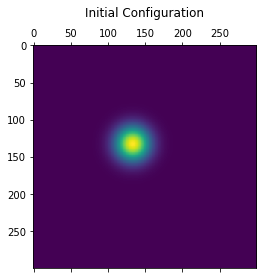

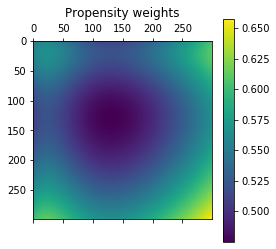

Effective time = 0.0000

Process @0/50000000 (0.00/100)
Normalized sum of grid 0.01857030
Elapsed time = 1.121seconds




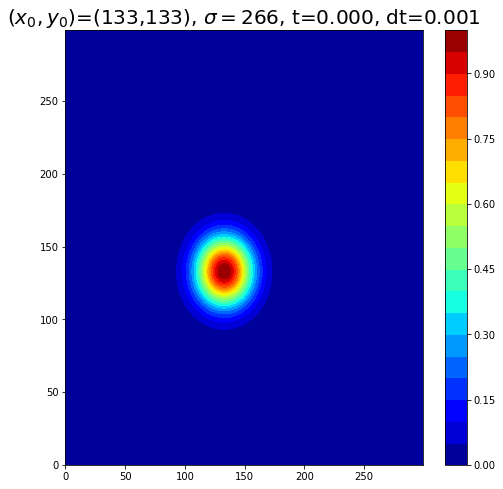

In [ ]:
#shift order to simulate test or paper configuration
size = 200
std = size*.886/3
center = [size*.443,size*.443] #to have the same ratio from the paper

size = 300
std = 266
center = [133,133]

dt = .001
t_end = 50000

x, y = np.mgrid[0:size:1, 0:size:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(center, [[std,0], [0, std]])
grid = np.float32(np.multiply(np.full([size,size],1),rv.pdf(pos)))

grid= grid/np.max(grid) #normalize
grid[grid < 1e-10] = 0  #threshold


grid = convert_to_df(grid)
plt.matshow(grid)
plt.title("Initial Configuration",y=1.1)
plt.show()
#execute and returns path of data output 
output_path = time_ev_mat(grid,t_end=t_end,dt=dt) 

In [146]:
def display_sequence_contourf_out(output_path,t_end):
    """Slider implementation of visualization over time"""
    def _show(frame=(0, t_end-1)):
        data = get_data(output_path[0],t_end)
        plt.figure(figsize=[7,7])
        plt.style.use('seaborn-white')
        plt.title("%d frame (t = %.3f)"%(int(frame*(t_end/(dt*100))*dt),frame*1000*dt),y=1.1)#n = save every
        plt.contourf(get_configuration_out(data,frame),10,cmap='Spectral') # n equally spaced lines
        plt.colorbar()
        #plt.clim(0,1)
        plt.show()
    return interact(_show)

def get_configuration_out(data,t):
    """Get configuration from data at a given time"""
    return convert_to_df(np.asarray(data.iloc[t]).reshape(size,size))

In [147]:
#data = get_data(output_path[0],t_end)
#plt.contourf(get_configuration_out(data,2),10,cmap='Spectral') # n equally spaced lines
display_sequence_contourf_out(output_path,output_path[1])

NameError: name 'output_path' is not defined

In [ ]:
# data = get_data(output_path[0],output_path[1])


# # In[53]:


# def get_configuration_out(data,t):
#     """Get configuration from data at a given time"""
#     return convert_to_df(np.asarray(data.iloc[t]).reshape(size,size))


# # In[73]:


# fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,5))
# ncolors = 15
# cmap ="jet"
# fig.suptitle("Configurations for %d x %d grid, $(x_{0},y_{0})=(%d,%d)$, $\\sigma=%d, t_{end}=%d$"%(size,size,center[0],center[1],std,t_end),fontsize=20,y=1.)

# im0 = axes[0].contourf(get_configuration_out(data, 0),ncolors,cmap=cmap) # n equally spaced lines
# divider = make_axes_locatable(axes[0])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im0, cax=cax, orientation='vertical')

# im1 = axes[1].contourf(get_configuration_out(data, int(output_path[1]/2)),ncolors,cmap=cmap) # n equally spaced lines
# divider = make_axes_locatable(axes[1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical')

# im2 = axes[2].contourf(get_configuration_out(data, int(output_path[1]*3/4)),ncolors,cmap=cmap) # n equally spaced lines
# divider = make_axes_locatable(axes[2])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical')


# im3 = axes[3].contourf(get_configuration_out(data, int(output_path[1]-1)),ncolors,cmap=cmap) # n equally spaced lines
# divider = make_axes_locatable(axes[3])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im3, cax=cax, orientation='vertical')

# #titles

# axes[0].set_title('T = 0',fontsize=16)
# axes[1].set_title('T = $\\frac{%d}{%d}\,\,t_{end}$'%(1,2),fontsize=16)
# axes[2].set_title('T = $\\frac{%d}{%d}\,\,t_{end}$'%(3,4),fontsize=16)
# axes[3].set_title('T = $t_{end}$',fontsize=16)

# #labels
# axes[0].set_ylabel("B species",fontsize=16)
# axes[0].set_ylabel("B species",fontsize=16)
# axes[0].set_xlabel("A species",fontsize=16)
# axes[1].set_xlabel("A species",fontsize=16)
# axes[2].set_xlabel("A species",fontsize=16)
# axes[3].set_xlabel("A species",fontsize=16)

# fig.subplots_adjust(wspace=.4,top=.85)

# plt.savefig(create_size_folderdata(size)+"/"+"t_end=%d.png"%(t_end))
# plt.show()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
1,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
2,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,...,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003
3,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,...,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004
4,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,...,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005
5,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,...,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006
6,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,...,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007
7,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,...,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008
8,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,...,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009
9,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,...,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010


In [117]:
x = np.full(shape=[3,3],fill_value=1.,dtype="float32")
y = np.full(shape=[3,3],fill_value=-3.3,dtype="float32")


array([[4.3, 4.3, 4.3],
       [4.3, 4.3, 4.3],
       [4.3, 4.3, 4.3]], dtype=float32)

In [111]:
from scipy.linalg import get_blas_funcs
gemm = get_blas_funcs("gemm", [x, y])
gemm(3, y, x) 

array([[-29.699999, -29.699999, -29.699999],
       [-29.699999, -29.699999, -29.699999],
       [-29.699999, -29.699999, -29.699999]], dtype=float32)

array([[0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05]], dtype=float32)